In [ ]:
!pip install torch gym matplotlib


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-2-cf20ba9a0839>:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

Episode 1, Reward: -1363.3467165715974
Episode 2, Reward: -1083.0611633320086
Episode 3, Reward: -1870.5449569690982
Episode 4, Reward: -1723.0427907353426
Episode 5, Reward: -1712.5856538945416
Episode 6, Reward: -1804.0062002641887
Episode 7, Reward: -1397.839174834134
Episode 8, Reward: -1295.2901443576784
Episode 9, Reward: -1147.126606883282
Episode 10, Reward: -1341.8457820903045
Episode 11, Reward: -1311.5229972771185
Episode 12, Reward: -1276.895179935694
Episode 13, Reward: -1242.0766955392423
Episode 14, Reward: -910.4376855952244
Episode 15, Reward: -1187.7064274564218
Episode 16, Reward: -1271.4371704284792
Episode 17, Reward: -1222.7676233336135
Episode 18, Reward: -1147.7531677610195
Episode 19, Reward: -1315.9272192168226
Episode 20, Reward: -1157.4017137557112
Episode 21, Reward: -1167.3987819902793
Episode 22, Reward: -1229.61317454734
Episode 23, Reward: -1351.2048107795263
Episode 24, Reward: -1142.8188443572963
Episode 25, Reward: -1096.0827677158115
Episode 26, Rew

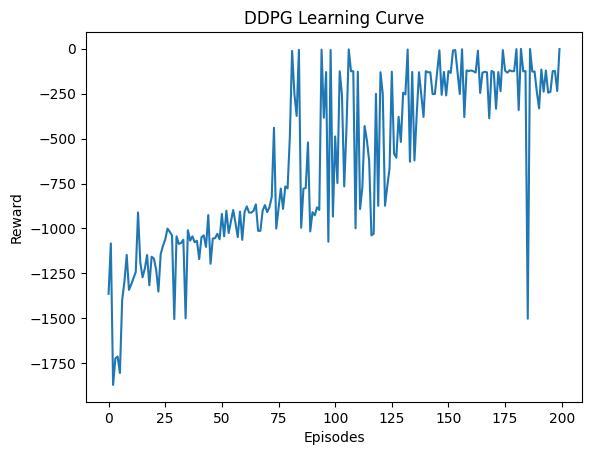

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
from collections import deque
import random

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.max_action * torch.tanh(self.fc3(x))

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, x, u):
        x = torch.relu(self.fc1(torch.cat([x, u], dim=1)))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.FloatTensor(states), torch.FloatTensor(actions),
                torch.FloatTensor(rewards).unsqueeze(1),
                torch.FloatTensor(next_states), torch.FloatTensor(dones).unsqueeze(1))

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer(max_size=1_000_000)
        self.discount = 0.99
        self.tau = 0.005

    def select_action(self, state, explore=True):
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        if explore:
            noise = np.random.normal(0, 0.1, size=action.shape)
            action = np.clip(action + noise, -self.max_action, self.max_action)
        return action

    def train(self, batch_size=64):
        if len(self.replay_buffer.buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        # Critic update
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_q = self.critic_target(next_states, next_actions)
            target_q = rewards + self.discount * (1 - dones) * target_q
        current_q = self.critic(states, actions)
        critic_loss = nn.MSELoss()(current_q, target_q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor update
        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft updates
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

# Training and Visualization
env = gym.make("Pendulum-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

gamma = DDPGAgent(state_dim, action_dim, max_action)

def train_ddpg(agent, env, episodes=200):
    rewards = []
    for ep in range(episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            agent.train()
        rewards.append(episode_reward)
        print(f"Episode {ep+1}, Reward: {episode_reward}")
    plt.plot(rewards)
    plt.title("DDPG Learning Curve")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.show()

train_ddpg(gamma, env, episodes=200)


Episode 1, Reward: -1460.6223873539168
Episode 2, Reward: -1558.1923710698832
Episode 3, Reward: -1256.5973554760021
Episode 4, Reward: -1502.862164094489
Episode 5, Reward: -1285.57627062573
Episode 6, Reward: -1240.8174516833042
Episode 7, Reward: -1185.7165388344392
Episode 8, Reward: -1149.2752163905184
Episode 9, Reward: -1194.0076385398122
Episode 10, Reward: -1007.6136601872199
Episode 11, Reward: -1175.292222018433
Episode 12, Reward: -1664.8597729286485
Episode 13, Reward: -1171.3187155252792
Episode 14, Reward: -1221.1372710474186
Episode 15, Reward: -1188.183894363278
Episode 16, Reward: -1050.9851622981537
Episode 17, Reward: -1021.4092493276185
Episode 18, Reward: -938.6686948515126
Episode 19, Reward: -1021.2704556582247
Episode 20, Reward: -892.1510431651828
Episode 21, Reward: -1006.2298267428354
Episode 22, Reward: -1553.7170523185735
Episode 23, Reward: -898.2739073849061
Episode 24, Reward: -867.7726810223502
Episode 25, Reward: -1648.787264223051
Episode 26, Reward:

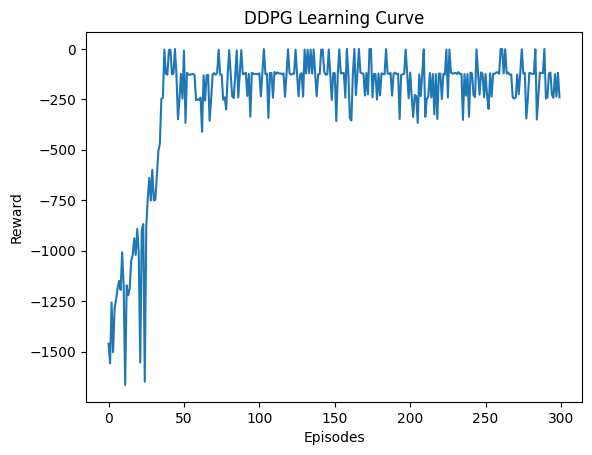

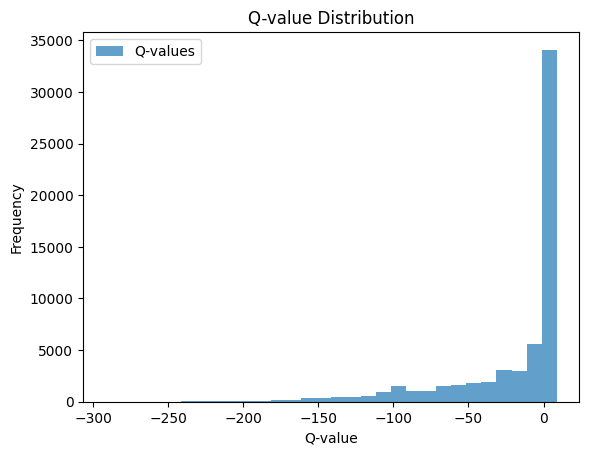

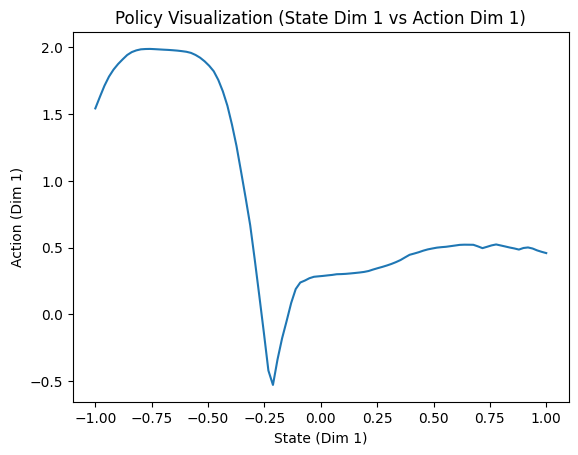

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
from collections import deque
import random

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.max_action * torch.tanh(self.fc3(x))

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, x, u):
        x = torch.relu(self.fc1(torch.cat([x, u], dim=1)))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.FloatTensor(states), torch.FloatTensor(actions),
                torch.FloatTensor(rewards).unsqueeze(1),
                torch.FloatTensor(next_states), torch.FloatTensor(dones).unsqueeze(1))

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer(max_size=1_000_000)
        self.discount = 0.99
        self.tau = 0.005

    def select_action(self, state, explore=True):
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        if explore:
            noise = np.random.normal(0, 0.1, size=action.shape)
            action = np.clip(action + noise, -self.max_action, self.max_action)
        return action

    def train(self, batch_size=64):
        if len(self.replay_buffer.buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        # Critic update
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_q = self.critic_target(next_states, next_actions)
            target_q = rewards + self.discount * (1 - dones) * target_q
        current_q = self.critic(states, actions)
        critic_loss = nn.MSELoss()(current_q, target_q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor update
        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft updates
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

# Training and Visualization
def train_ddpg(agent, env, episodes=200):
    rewards = []
    q_values = []
    for ep in range(episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            agent.train()
            with torch.no_grad():
                q_values.append(agent.critic(torch.FloatTensor(state).unsqueeze(0), torch.FloatTensor(action).unsqueeze(0)).item())
        rewards.append(episode_reward)
        print(f"Episode {ep+1}, Reward: {episode_reward}")

    # Learning curve
    plt.plot(rewards)
    plt.title("DDPG Learning Curve")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.show()

    # Q-value distribution
    plt.hist(q_values, bins=30, alpha=0.7, label="Q-values")
    plt.title("Q-value Distribution")
    plt.xlabel("Q-value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

def visualize_policy(agent, env):
    # Assume we visualize along the first state dimension
    state_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 100)
    actions = []
    for state in state_space:
        state_input = np.zeros(env.observation_space.shape)  # Initialize full state
        state_input[0] = state  # Only vary the first dimension
        action = agent.select_action(state_input, explore=False)
        actions.append(action[0])  # First dimension of action

    plt.plot(state_space, actions)
    plt.title("Policy Visualization (State Dim 1 vs Action Dim 1)")
    plt.xlabel("State (Dim 1)")
    plt.ylabel("Action (Dim 1)")
    plt.show()

# Environment setup
env = gym.make("Pendulum-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

agent = DDPGAgent(state_dim, action_dim, max_action)

train_ddpg(agent, env, episodes=300)
visualize_policy(agent, env)


Running experiment with seed 0
Seed 0, Episode 1, Reward: -1225.284907032843
Seed 0, Episode 2, Reward: -1841.6101295199273
Seed 0, Episode 3, Reward: -1772.3932436008529
Seed 0, Episode 4, Reward: -1532.3704246713128
Seed 0, Episode 5, Reward: -1435.4222843478708
Seed 0, Episode 6, Reward: -1509.2661839029297
Seed 0, Episode 7, Reward: -1523.1306889013558
Seed 0, Episode 8, Reward: -1489.1229665978758
Seed 0, Episode 9, Reward: -1532.5828858844945
Seed 0, Episode 10, Reward: -1462.0208940393852
Seed 0, Episode 11, Reward: -1524.6574450578378
Seed 0, Episode 12, Reward: -1466.7740879402425
Seed 0, Episode 13, Reward: -1381.1966505814635
Seed 0, Episode 14, Reward: -1411.605682957192
Seed 0, Episode 15, Reward: -1220.4825264265596
Seed 0, Episode 16, Reward: -1158.9699374059912
Seed 0, Episode 17, Reward: -1247.4959809304348
Seed 0, Episode 18, Reward: -990.9219935587917
Seed 0, Episode 19, Reward: -862.5347458763495
Seed 0, Episode 20, Reward: -1506.571214082686
Seed 0, Episode 21, Rew

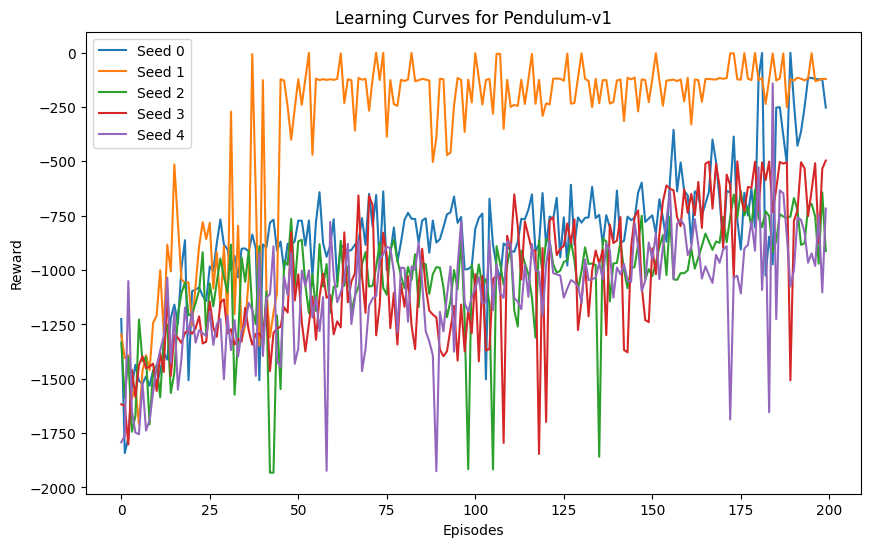

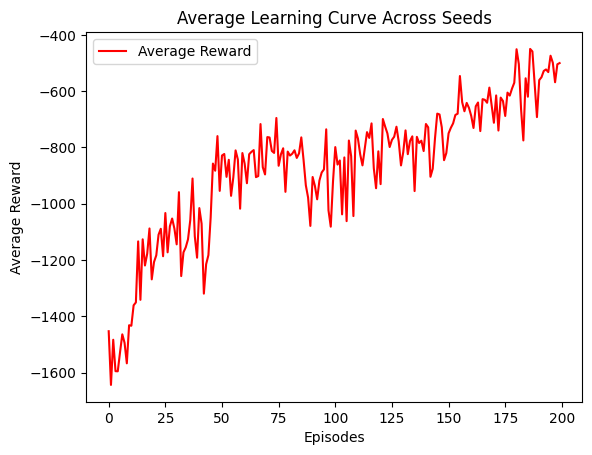

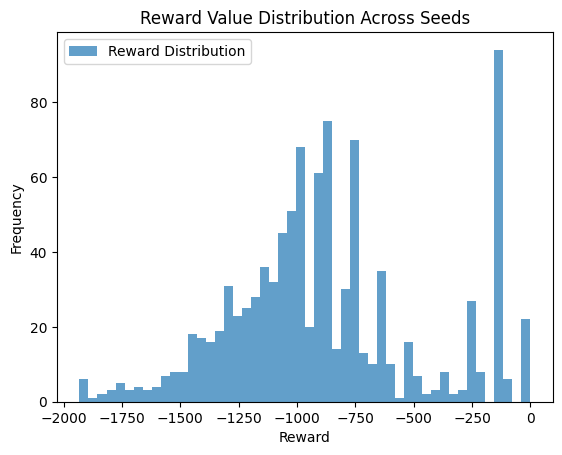

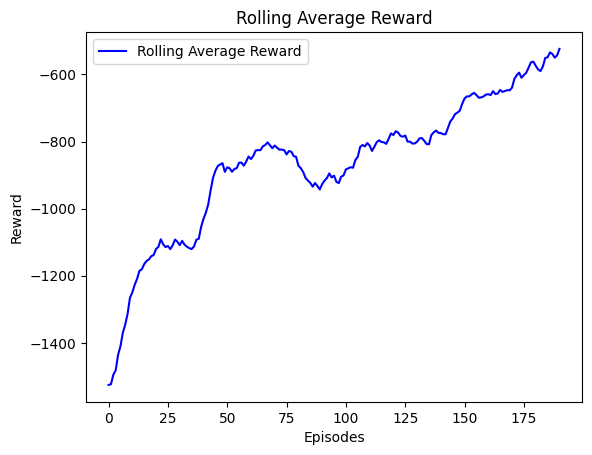

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
from collections import deque
import random

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.max_action * torch.tanh(self.fc3(x))

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, x, u):
        x = torch.relu(self.fc1(torch.cat([x, u], dim=1)))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.FloatTensor(states), torch.FloatTensor(actions),
                torch.FloatTensor(rewards).unsqueeze(1),
                torch.FloatTensor(next_states), torch.FloatTensor(dones).unsqueeze(1))

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer(max_size=1_000_000)
        self.discount = 0.99
        self.tau = 0.005

    def select_action(self, state, explore=True):
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        if explore:
            noise = np.random.normal(0, 0.1, size=action.shape)
            action = np.clip(action + noise, -self.max_action, self.max_action)
        return action

    def train(self, batch_size=64):
        if len(self.replay_buffer.buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        # Critic update
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_q = self.critic_target(next_states, next_actions)
            target_q = rewards + self.discount * (1 - dones) * target_q
        current_q = self.critic(states, actions)
        critic_loss = nn.MSELoss()(current_q, target_q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor update
        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft updates
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

# Training and Visualization

def train_with_multiple_seeds(agent_class, env_name, seeds, episodes=200):
    results = {}
    all_rewards = []
    learning_rates = []

    for seed in seeds:
        print(f"Running experiment with seed {seed}")
        np.random.seed(seed)
        torch.manual_seed(seed)
        env = gym.make(env_name)
        env.seed(seed)

        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        max_action = float(env.action_space.high[0])

        agent = agent_class(state_dim, action_dim, max_action)
        rewards = []
        episode_learning_rates = []

        for ep in range(episodes):
            state = env.reset()
            episode_reward = 0
            done = False
            while not done:
                action = agent.select_action(state)
                next_state, reward, done, _ = env.step(action)
                agent.replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                agent.train()
            rewards.append(episode_reward)
            episode_learning_rates.append(agent.actor_optimizer.param_groups[0]['lr'])
            print(f"Seed {seed}, Episode {ep+1}, Reward: {episode_reward}")

        results[seed] = rewards
        all_rewards.append(rewards)
        learning_rates.append(episode_learning_rates)

    # Plot the learning curves
    plt.figure(figsize=(10, 6))
    for seed, rewards in results.items():
        plt.plot(rewards, label=f"Seed {seed}")
    plt.title(f"Learning Curves for {env_name}")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

    # Average rewards
    avg_rewards = np.mean(all_rewards, axis=0)
    plt.plot(avg_rewards, label="Average Reward", color="red")
    plt.title("Average Learning Curve Across Seeds")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.show()

    # Reward value distribution
    plt.hist(np.concatenate(all_rewards), bins=50, alpha=0.7, label="Reward Distribution")
    plt.title("Reward Value Distribution Across Seeds")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Rolling average reward
    window_size = 10
    rolling_avg = np.convolve(avg_rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(rolling_avg, label="Rolling Average Reward", color="blue")
    plt.title("Rolling Average Reward")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

# Heatmap Visualization
def heatmap_visualization(agent, env):
    state_range = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 50)
    action_range = np.linspace(env.action_space.low[0], env.action_space.high[0], 50)
    q_values = np.zeros((len(state_range), len(action_range)))

    for i, state in enumerate(state_range):
        for j, action in enumerate(action_range):
            state_tensor = torch.FloatTensor([state]).unsqueeze(0)
            action_tensor = torch.FloatTensor([action]).unsqueeze(0)
            q_values[i, j] = agent.critic(state_tensor, action_tensor).item()

    plt.imshow(q_values, extent=(env.action_space.low[0], env.action_space.high[0], env.observation_space.low[0], env.observation_space.high[0]), origin="lower", aspect="auto", cmap="viridis")
    plt.colorbar(label="Q-value")
    plt.title("Heatmap of Q-values")
    plt.xlabel("Action")
    plt.ylabel("State")
    plt.show()

# Environment setup for Pendulum-v1
env_name = "Pendulum-v1"
seeds = [0, 1, 2, 3, 4]

train_with_multiple_seeds(DDPGAgent, env_name, seeds, episodes=200)
